#### download  dataset

In [ ]:
#!pip install datasets

In [2]:
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


In [5]:

cifar10 = load_dataset('cifar10')


Reusing dataset cifar10 (C:\Users\Imagry\.cache\huggingface\datasets\cifar10\plain_text\1.0.0\447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 105.54it/s]


c:\users\imagry\desktop\linux\converter\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  


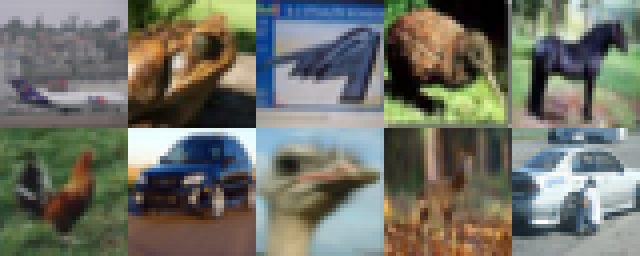

In [6]:

# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

### Utils

In [12]:
def img_to_tensor(im):
    return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
    return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)


### Adding Noise

In [18]:
n_steps = 100 # number of noising steps
beta = torch.linspace(0.0001, 0.04, n_steps)



In [26]:
def add_noise_one_step(xtm1,t):
    mean = gather(1. - beta, t) ** 0.5 * xtm1 # √(1−βt)*xtm1
    var = gather(beta, t) # βt I
    
    eps = torch.randn_like(xtm1) # Noise shaped like xtm1
    return mean + (var ** 0.5) * eps


In [60]:
def add_noise_multi_step(xtm1,n_of_steps):
    x = img_to_tensor(xtm1).squeeze()

    for t in range(n_of_steps):
        t = torch.tensor(t, dtype=torch.long) 
        
        x = add_noise_one_step(x, t)
    return x
        

In [76]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)


def add_noise_multi_step_fast(x0, t):
    x0 = img_to_tensor(x0).squeeze()
    t = torch.tensor(t, dtype=torch.long)
    
    mean = gather(alpha_bar, t) ** 0.5 * x0 # now alpha_bar
    var = 1-gather(alpha_bar, t) # (1-alpha_bar)
    eps = torch.randn_like(x0)
    return mean + (var ** 0.5) * eps

c:\users\imagry\desktop\linux\converter\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  


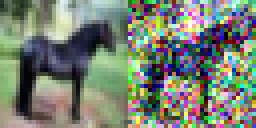

In [77]:
# Show im at different stages
im = cifar10['train'][4]['img']
image = Image.new('RGB', size=(32*2, 32))

image.paste(im, ((0, 0)))

#add noise
#im2=add_noise_multi_step(im,50)
im2=add_noise_multi_step_fast(im,40)

im2=tensor_to_image(im2)
            
image.paste(im2, ((32, 0)))


image.resize((32*4*2, 32*4), Image.NEAREST)

# UNet